<a href="https://colab.research.google.com/github/giordamaug/BIOMAT2022/blob/main/notebooks/BIOMAT2022_workbench_allproblems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
# Cloning BIOMAT2022 repository

In [1]:
!git clone http://github.com/giordamaug/BIOMAT2022
!pip install -q lightgbm
!pip install -q tabulate
%cd /content/BIOMAT2022

Cloning into 'BIOMAT2022'...
remote: Enumerating objects: 531, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 531 (delta 70), reused 121 (delta 57), pack-reused 395
Receiving objects: 100% (531/531), 576.30 MiB | 13.68 MiB/s, done.
Resolving deltas: 100% (274/274), done.
Checking out files: 100% (102/102), done.
/content/BIOMAT2022


# Import required packages

In [17]:
import pandas as pd
import numpy as np
import os
import sys
if 'google.colab' in sys.modules:
	import tqdm.notebook as tq
else:
	import tqdm as tq
import pandas as pd


## Inititialization of some parameters

In [18]:
#@title  { form-width: "10%" }
seed = 1 #@param {type:"integer"}
class bcolors:
    HEADER = '\033[95m\033[1m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

classifier_map = {'RF' : 'RandomForestClassifier', 
                  'MLP': 'MLPClassifier', 
                  'SVM' : 'SVC', 
                  'RUS':  'RUSBoostClassifier',
                  'XGB': 'XGBClassifier',
                  'LGBM': 'LGBMClassifier'}

classifiers_args = {
  'RF' : {'random_state' : seed, 'class_weight': 'balanced'}, 
  'MLP': {'random_state' : seed}, 
  'SVM' : {'random_state' : seed, 'class_weight': 'balanced'}, 
  'RUS': {'random_state' : seed},
  'XGB': {'random_state' : seed, 'eval_metric' : 'logloss', 'scale_pos_weight' : 0.2},
  'LGBM': {'random_state' : seed, 'class_weight': 'balanced'}
}

# Load labels
Gene labels are loaded before gene attributes loading. 
The final list of genes `selectedgenes` is the intersection of the subset of genes with attributes and the subset of labelled genes.

In [62]:
data_dir = "BRAIN" #@param {type:"string"}
label_filename = "node_labels.csv" #@param {type:"string"}
labelname = "most_freq" #@param {type:"string"}
problem = "E vs NE" #@param ["E vs NE", "E vs Ea vs aNE vs NE", "E vs aE", "E vs aNE vs NE", "(E + aE) vs (aNE + NE)", "E vs (aNE + NE)", "E vs aE vs (aNE + NE)"]
if problem == "E vs NE":
  label_aliases = {}
  exclude_labels = ['aE', 'aNE']
elif problem == "E vs Ea vs aNE vs NE":
  label_aliases = {}
  exclude_labels = []
elif problem == "E vs aE":
  label_aliases = {}
  exclude_labels = ['aNE', 'NE']
elif problem == "E vs aNE vs NE":
  label_aliases = {}
  exclude_labels = ['aE']
elif problem == "(E + aE) vs (aNE + NE)":
  label_aliases = {'aE' : 'E + aE', 'E' : 'E + aE', 'aNE' : 'aNE + NE', 'NE' : 'aNE + NE'}
  exclude_labels = []
elif problem == "E vs (aNE + NE)":
  label_aliases = {'aNE' : 'aNE + NE', 'NE' : 'aNE + NE'}
  exclude_labels = ['aE']
elif problem == "E vs aE vs (aNE + NE)":
  label_aliases = {'aNE' : 'aNE + NE', 'NE' : 'aNE + NE'}
  exclude_labels = []
else:
  print(bcolors.FAIL + f'\tWrong problem {problem}!' + bcolors.ENDC)
label_file = os.path.join(data_dir, "node_labels.csv")
df_label = pd.read_csv(label_file, sep=',', index_col=0)
if labelname in df_label.columns:
    print(bcolors.HEADER + f'Loading label {labelname} from file "{label_file}"...' + bcolors.ENDC)
else:
    print(bcolors.FAIL + f'FAIL: Label name {labelname} is not in the label file {label_filename}!' + bcolors.ENDC)
dup = df_label.index.duplicated().sum()
if dup > 0:
    print(bcolors.OKGREEN + f'\tRemoving {dup} duplicated genes...' + bcolors.ENDC)
    df_label = df_label[~df_label.index.duplicated(keep='first')]
genes = df_label.index.values                                            # get genes with defined labels
df_label = df_label[df_label[labelname].isin([np.nan] + exclude_labels) == False]                      # drop any row contaning NaN or SC1-SC5 as value
labels = np.unique(df_label[labelname].values)
print(bcolors.OKGREEN + f'\tOriginal label values in {labels}' + bcolors.ENDC)
for key,newkey in label_aliases.items():
    if key in labels:
        print(bcolors.OKGREEN + f'\treplacing label {key} with {newkey}' + bcolors.ENDC)
        df_label = df_label.replace(key, newkey)
labels = np.unique(df_label[labelname].values)
print(bcolors.OKGREEN + f'\tFinal label values in {labels}' + bcolors.ENDC)
selectedgenes = df_label.index.values
print(bcolors.OKGREEN + f'\t{len(selectedgenes)} labeled genes over a total of {len(genes)}' + bcolors.ENDC)
df_label

Loading label most_freq from file "/Users/maurizio/BIOMAT2022/BRAIN/node_labels.csv"...
	Original label values in ['E' 'aE']
	Final label values in ['E' 'aE']
	1746 labeled genes over a total of 17386


,ACH.000025,ACH.000036,ACH.000040,ACH.000067,ACH.000075,ACH.000095,ACH.000098,ACH.000120,ACH.000128,ACH.000137,...,ACH.002278,ACH.002280,ACH.002282,ACH.002283,ACH.002284,ACH.002285,ACH.002461,ACH.002680,ACH.002875,most_freq
name,,,,,,,,,,,,,,,,,,,,,
AAMP,aE,E,aE,aE,E,E,aE,E,E,E,...,E,E,E,aE,E,E,aE,aE,aE,E
AARS1,E,E,E,E,E,E,E,E,E,E,...,E,E,E,E,E,E,E,E,E,E
AASDHPPT,aNE,aE,aNE,aNE,aNE,aNE,aNE,aNE,aE,aE,...,aNE,aE,aNE,aNE,aE,aE,aNE,aE,aNE,aE
AATF,aE,E,aE,E,aE,E,aE,aE,aE,aE,...,aE,aE,E,E,E,E,aE,aE,aE,aE
ABCB7,aE,aE,aE,aE,E,E,E,aE,E,E,...,aE,E,E,E,E,E,aE,aE,E,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNHIT3,aE,aE,aE,aE,aE,aNE,aE,aE,aE,aNE,...,E,aE,aE,aE,aE,E,aNE,aE,aNE,aE
ZNHIT6,aE,aE,aE,aE,aE,aE,aE,aE,aE,aNE,...,aE,aE,aE,aE,aE,aNE,aE,aE,aE,aE
ZPR1,E,E,E,E,E,E,E,E,E,E,...,E,E,E,E,E,E,E,E,E,E


 # Load gene attributes

Fixing NaN and infinity values

In [63]:

attr_filename = "node_attributes.csv" #@param {type:"string"}
x = pd.read_csv(os.path.join(data_dir, attr_filename), index_col=0)
x = x.select_dtypes(include=np.number)     # drop non numeric attributes
dup = x.index.duplicated().sum()
if dup > 0:
    print(bcolors.OKGREEN + f'\tRemoving {dup} duplicated genes...' + bcolors.ENDC)
    x = x[~x.index.duplicated(keep='first')]
droppedcol = 0
nancount = x.isnull().sum().sum()
for col in x.columns[x.isna().any()].tolist():
    mean_value=x[col].mean()          # Replace NaNs in column with the mean of values in the same column
    if mean_value is not np.nan:
        x[col].fillna(value=mean_value, inplace=True)
    else:                             # otherwise, if the mean is NaN, remove the column
        x = x.drop(col, 1)
print(bcolors.HEADER + f'Fix: {nancount} NaN values - {np.isinf(x).values.sum()} Infinite value - {droppedcol} dropped null columns' + bcolors.ENDC)


Fix: 72521 NaN values - 0 Infinite value - 0 dropped null columns


data normalization

In [64]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3

normalize_node = "zscore" #@param ["minmax", "zscore", ""]
if normalize_node == 'minmax':
    print(bcolors.OKGREEN + "\tgene attributes normalization (minmax)..." + bcolors.ENDC)
    x = (x-x.min())/(x.max()-x.min())
elif normalize_node == 'zscore':
    print(bcolors.OKGREEN + "\tgene attributes normalization (zscore)..." + bcolors.ENDC)
    x = (x-x.mean())/x.std()
selectedgenes = intersection(x.index.to_list(), selectedgenes)
print(bcolors.OKGREEN + f'\tgenes with attributes are {len(selectedgenes)}' + bcolors.ENDC)
x = x.loc[selectedgenes]
x = x[~x.index.duplicated(keep='first')]   # remove eventually duplicated index
print(bcolors.OKGREEN + f'\tNew attribute matrix x{x.shape}' + bcolors.ENDC)
x

	gene attributes normalization (zscore)...
	genes with attributes are 1723
	New attribute matrix x(1723, 37)


,gene_length,transcript_count,gc_content,Gtex_brain,gene_disease_ass_count,oncodb_expression,HPA_brain_mean,orth_count,Mitochondrion,Nucleus,...,Driver_genes_MET_GBM,Driver_genes_MET_LGG,mf,bp,cc,biogrid,kegg,reactome,ucsc_tfbs,up_tissue
name,,,,,,,,,,,,,,,,,,,,,
AAMP,-0.487074,0.120401,1.258879,1.800023e-02,-1.900073e-14,2.601827e-02,-0.010229,0.939178,4.470075e-01,2.073260e-01,...,NaN,NaN,-0.734532,-0.450184,-0.023744,-0.239536,-3.463728e-01,1.737934e-01,8.031218e-01,-0.083951
AARS1,-0.245688,3.554614,0.375208,2.632489e-16,-6.163353e-01,3.631062e-14,-0.008093,0.789851,-1.832695e-14,2.486499e-14,...,NaN,NaN,1.279865,-0.085366,-0.023744,0.182064,-1.688393e-01,-5.498610e-01,2.403336e-01,0.431585
AASDHPPT,-0.356387,-0.416195,-1.304412,-6.624041e-03,-1.900073e-14,-5.905414e-01,-0.023390,0.981843,4.470075e-01,2.073260e-01,...,NaN,NaN,-0.446761,-0.358979,-0.795016,-0.187761,8.694186e-03,-5.498610e-01,-1.222916e+00,2.235963
AATF,0.289835,0.013082,-0.794850,-2.593786e-02,-1.900073e-14,3.631062e-14,-0.028242,0.939178,4.470075e-01,2.073260e-01,...,NaN,NaN,0.128781,0.279452,0.233347,0.677630,-3.463728e-01,-4.051301e-01,2.013116e+00,0.689354
ABCB7,0.272216,0.871635,-1.376654,-3.775330e-02,7.624868e-03,1.087253e+00,-0.036366,0.939178,4.470075e-01,2.073260e-01,...,NaN,NaN,0.416552,0.005839,-0.537925,0.411356,-1.688393e-01,-4.774956e-01,7.187036e-01,-0.083951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNHIT3,-0.436534,0.335039,-0.116294,-2.465166e-02,-5.271982e-01,6.714108e-02,-0.022072,0.971177,4.470075e-01,2.073260e-01,...,NaN,NaN,-0.446761,-0.176570,-0.537925,-0.232140,-3.463728e-01,-1.300894e-13,-7.726851e-01,-0.083951
ZNHIT6,-0.083428,-0.738152,-1.316022,-3.756280e-02,-7.054725e-01,3.631062e-14,-0.035454,0.843182,-2.500752e+00,2.073260e-01,...,NaN,NaN,0.416552,-0.267775,-0.537925,-0.010245,-3.463728e-01,-1.300894e-13,-1.166637e+00,0.431585
ZPR1,-0.424653,0.013082,-0.280128,-3.554131e-02,-1.900073e-14,3.631062e-14,-0.033441,0.896513,4.470075e-01,2.073260e-01,...,NaN,NaN,-0.158990,1.191498,1.518800,-0.069417,-3.463728e-01,-1.300894e-13,-6.882668e-01,-0.341719


# Load gene embedding

In [65]:
embed_dir = os.path.join(data_dir, "embeddings")
embedder = "Node2Vec" #@param ["Node2Vec", "GLEE", "DeepWalk"]
embedsize = 64 #@param {type:"slider", min:32, max:128, step:32}
print(bcolors.HEADER + f'Embedding with method "{embedder}" and size {embedsize}...' + bcolors.ENDC)
embedfilename = os.path.join(embed_dir,f'PPI_{embedder}_{embedsize}.csv')
embedding_df = pd.read_csv(embedfilename, index_col=0)
dup = embedding_df.index.duplicated().sum()
if dup > 0:
    print(bcolors.OKGREEN + f'\tRemoving {dup} duplicated genes...' + bcolors.ENDC)
    embedding_df = embedding_df[~embedding_df.index.duplicated(keep='first')]
selectedgenes = intersection(selectedgenes, embedding_df.index.to_list())
print(bcolors.OKGREEN + f'\tgenes in the network are {len(selectedgenes)}' + bcolors.ENDC)
embedding_df = embedding_df.loc[selectedgenes]                                     # keep only embeddings of selected genes (those with labels)
x = embedding_df if x.empty else pd.concat([embedding_df, x], axis=1) 
print(bcolors.OKGREEN + f'\tNew attribute matrix x{x.shape}' + bcolors.ENDC)
x

Embedding with method "Node2Vec" and size 64...
	genes in the network are 1723
	New attribute matrix x(1723, 101)


,Node2Vec_1,Node2Vec_2,Node2Vec_3,Node2Vec_4,Node2Vec_5,Node2Vec_6,Node2Vec_7,Node2Vec_8,Node2Vec_9,Node2Vec_10,...,Driver_genes_MET_GBM,Driver_genes_MET_LGG,mf,bp,cc,biogrid,kegg,reactome,ucsc_tfbs,up_tissue
name,,,,,,,,,,,,,,,,,,,,,
AAMP,1.152391,0.321304,0.516014,-0.306979,-0.547550,-1.137435,0.846567,-2.375952,-0.212079,0.090333,...,NaN,NaN,-0.734532,-0.450184,-0.023744,-0.239536,-3.463728e-01,1.737934e-01,8.031218e-01,-0.083951
AARS1,-0.074896,-1.515353,0.054215,-0.785363,0.774651,-0.288977,-0.403300,0.224871,0.081541,-1.524166,...,NaN,NaN,1.279865,-0.085366,-0.023744,0.182064,-1.688393e-01,-5.498610e-01,2.403336e-01,0.431585
AASDHPPT,-1.274857,-2.191984,0.618041,-0.160880,-0.366893,0.159453,0.705739,0.430908,-1.199351,-1.391912,...,NaN,NaN,-0.446761,-0.358979,-0.795016,-0.187761,8.694186e-03,-5.498610e-01,-1.222916e+00,2.235963
AATF,0.327544,0.276729,-1.181808,-0.559573,2.227724,-0.414724,0.478061,0.268316,-0.922675,0.366858,...,NaN,NaN,0.128781,0.279452,0.233347,0.677630,-3.463728e-01,-4.051301e-01,2.013116e+00,0.689354
ABCB7,-0.351753,-1.436967,0.343368,0.954116,0.491267,0.862197,0.654363,-0.845988,0.751069,0.011802,...,NaN,NaN,0.416552,0.005839,-0.537925,0.411356,-1.688393e-01,-4.774956e-01,7.187036e-01,-0.083951
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZNHIT3,-0.357334,-0.131233,-0.169363,-0.032123,-0.451406,1.336242,-0.129023,-1.393898,-1.247477,0.660962,...,NaN,NaN,-0.446761,-0.176570,-0.537925,-0.232140,-3.463728e-01,-1.300894e-13,-7.726851e-01,-0.083951
ZNHIT6,0.085690,1.166099,0.472239,-0.373496,-0.267522,0.460412,1.039717,-0.748097,-0.702590,0.555792,...,NaN,NaN,0.416552,-0.267775,-0.537925,-0.010245,-3.463728e-01,-1.300894e-13,-1.166637e+00,0.431585
ZPR1,-0.191499,-0.637074,-0.343115,-0.408474,-1.101605,-0.377114,-0.172605,0.165450,-0.293139,-0.087475,...,NaN,NaN,-0.158990,1.191498,1.518800,-0.069417,-3.463728e-01,-1.300894e-13,-6.882668e-01,-0.341719


In [66]:
pd.concat([x, df_label['most_freq']], axis=1).to_csv(os.path.join(data_dir,"dataset.csv"))

## Label distribution of genes

Show label distribution ...
	Working on label "most_freq": {'E': 0, 'aE': 1} ['E' 'aE'] {'E': 870, 'aE': 853}


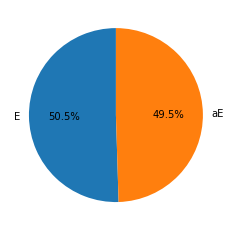

In [67]:
from collections import Counter, OrderedDict
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
labels = df_label.loc[selectedgenes][labelname].values
distrib = Counter(labels)
encoder = LabelEncoder()
y = encoder.fit_transform(labels)  
classes_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
rev_classes_mapping = np.array(list(classes_mapping.keys()))

plt.pie(list(distrib.values()), labels=list(distrib.keys()), autopct='%2.1f%%', startangle=90)
print(bcolors.HEADER + f'Show label distribution ...' + bcolors.ENDC)
print(bcolors.OKGREEN + f'\tWorking on label "{labelname}": {classes_mapping} {rev_classes_mapping} {dict(distrib)}' + bcolors.ENDC)


# Classification

Classification with method "LGBM"...


5-fold: 100%|██████████| 5/5 [00:02<00:00,  1.79it/s]


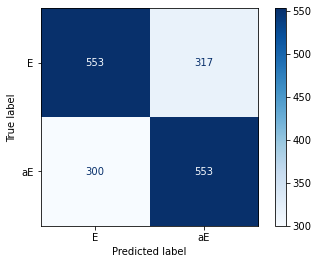

+------+-------------+-------------+---------------+---------------+-------------+-------------+
|      | Accuracy    | BA          | Sensitivity   | Specificity   | MCC         | CM          |
|------+-------------+-------------+---------------+---------------+-------------+-------------|
| LGBM | 0.642±0.025 | 0.642±0.025 | 0.636±0.042   | 0.648±0.027   | 0.284±0.049 | [[553 317]  |
|      |             |             |               |               |             |  [300 553]] |
+------+-------------+-------------+---------------+---------------+-------------+-------------+


In [70]:
#@title Choose classifier { run: "auto", form-width: "20%" }
method = "LGBM" #@param ["SVM", "XGB", "RF", "MLP", "RUS", "LGBM"]
import random
random.seed(seed)
np.random.seed(seed)
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector as selector
from sklearn.neural_network import MLPClassifier
import sys
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from tqdm import tqdm
from sklearn.metrics import *
from sklearn.ensemble import AdaBoostClassifier
from imblearn.ensemble import RUSBoostClassifier
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier
from tabulate import tabulate
nfolds = 5
kf = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=seed)
accuracies, mccs = [], []
genes = x.index.values
X = x.to_numpy()

nclasses = len(classes_mapping)
cma = np.zeros(shape=(nclasses,nclasses), dtype=int)
mm = np.array([], dtype=int)
gg = np.array([])
yy = np.array([], dtype=int)
predictions = np.array([])
columns_names = ["Accuracy","BA", "Sensitivity", "Specificity","MCC", 'CM']
scores = pd.DataFrame(columns=columns_names)
print(bcolors.HEADER + f'Classification with method "{method}"...')
for fold, (train_idx, test_idx) in enumerate(tqdm(kf.split(np.arange(len(X)), y), total=kf.get_n_splits(), desc=bcolors.OKGREEN +  f"{nfolds}-fold")):
    train_x, train_y, test_x, test_y = X[train_idx], y[train_idx], X[test_idx], y[test_idx],
    mm = np.concatenate((mm, test_idx))
    yy = np.concatenate((yy, test_y))
    gg = np.concatenate((gg, genes[test_idx]))
    clf = globals()[classifier_map[method]](**classifiers_args[method])
    preds = clf.fit(train_x, train_y).predict(test_x)
    cm = confusion_matrix(test_y, preds)
    cma += cm.astype(int)
    predictions = np.concatenate((predictions, preds))
    scores = scores.append(pd.DataFrame([[accuracy_score(test_y, preds), balanced_accuracy_score(test_y, preds), 
        cm[0,0]/(cm[0,0]+cm[0,1]), cm[1,1]/(cm[1,0]+cm[1,1]), 
        matthews_corrcoef(test_y, preds), cm]], columns=columns_names, index=[fold]))
dfm_scores = pd.DataFrame(scores.mean(axis=0, numeric_only=True)).T
dfs_scores = pd.DataFrame(scores.std(axis=0, numeric_only=True)).T
df_scores = pd.DataFrame([f'{row[0]:.3f}±{row[1]:.3f}' for row in pd.concat([dfm_scores,dfs_scores], axis=0).T.values.tolist()]).T
df_scores.index=[f'{method}']
df_scores['CM'] = [cma]
df_scores.columns = columns_names
disp = ConfusionMatrixDisplay(confusion_matrix=cma, display_labels=encoder.inverse_transform(clf.classes_))
disp.plot(cmap="Blues")
plt.show()
print(bcolors.OKGREEN +  tabulate(df_scores, headers='keys', tablefmt='psql') + bcolors.ENDC)

In [69]:
cma[[1,2],:] = cma[[2,1],:]
cma[:,[1,2]] = cma[:,[2,1]]
#cma[[2,3],:] = cma[[3,2],:]
#cma[:,[2,3]] = cma[:,[3,2]]
print(cma)
#disp = ConfusionMatrixDisplay(confusion_matrix=cma, display_labels=['E','aE','aNE','NE'])
disp = ConfusionMatrixDisplay(confusion_matrix=cma, display_labels=['E','aNE','NE'])
disp.plot(cmap="Blues")
plt.show()


IndexError: index 2 is out of bounds for axis 0 with size 2